In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

device = 'cuda:7'

load attribution, interpolation

In [98]:
import torch 
from ebm_pkg.models import get_model
import numpy as np 
import matplotlib.pyplot as plt 

MNIST_MEAN = [0.1307]
MNIST_STD  = [0.3081] 

CIFAR10_STATS = {
    'mean' : [0.4914, 0.4822, 0.4465],
    'std' : [0.2023, 0.1994, 0.2010]
}

root = '/data8/donghun/cifar10/untracked/'
valid_dataset = torchvision.datasets.CIFAR10(root = root,
                            train=False,
                            # download=True,
                            transform=T.Compose([T.ToTensor(), T.Normalize(mean = CIFAR10_STATS['mean'], std = CIFAR10_STATS['std'])]),
)

classifier = torch.load('/data8/donghun/cifar10/results/densenet/script_model.pt', map_location='cpu')

# path = f"/home/dhlee/code/paper_code_exercise/prev___ebm_classification/results/train/mnist/baseline/seed_0"

# configs = {
#     "cnn" : (10, 'relu' , 256, None), 
#     # "resnet18" : (flags.num_classes, 'relu', flags.cnn_dim, flags.avg_pool_size)
# }
# out_features, activation, cnn_dim, last_avg_kernel_size = configs['cnn']
# model = get_model('cnn', 
#                 in_channels=1,
#                 out_features=out_features,
#                 activation=activation,
#                 cnn_dim=cnn_dim,
#                 dropout_p = 0.5,
#                 last_avg_kernel_size=last_avg_kernel_size)
# model.load_state_dict(torch.load(f"{path}/model_best.pt", map_location='cpu'))
# classifier = model.eval().to(device)


/home/dhlee/anaconda3/envs/dh1/lib/python3.8/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [96]:
# index = {}
# for i, j in enumerate(valid_dataset):
#     _, label = j
#     if str(label) in index.keys():
#         index[f'{label}'] += 1
#     else:
#         index[f'{label}'] = 1 
# index
    

{'6': 5000,
 '9': 5000,
 '4': 5000,
 '1': 5000,
 '2': 5000,
 '7': 5000,
 '8': 5000,
 '3': 5000,
 '5': 5000,
 '0': 5000}

In [4]:
def make_key(keys, method, ratio):
    ans = []
    for i in keys:
        if method in i:
            if ratio in i:
                ans.append(i)
    return ans

# pred_key = make_key(avg.keys(), 'pred', '0.2')
# pred_key
                

Show metric

In [26]:
import json

with open("/home/dhlee/code/ig_inversion/results/latent/2/evaluation_average_cifar10.json", "r") as st_json:
    avg2 = json.load(st_json)

with open("/home/dhlee/code/ig_inversion/results/latent/8/evaluation_average_cifar10.json", "r") as st_json:
    avg8 = json.load(st_json)
    
with open("/home/dhlee/code/ig_inversion/results/latent/2/evaluation_samples_cifar10.json", "r") as st_json:
    all2 = json.load(st_json)

with open("/home/dhlee/code/ig_inversion/results/latent/8/evaluation_samples_cifar10.json", "r") as st_json:
    all8 = json.load(st_json)    

# with open("/home/dhlee/code/ig_inversion/results/mnist/evaluation_samples_cifar10.json", "r") as all_json:
#     all = json.load(all_json)


['aopc_0_0.2', 'aopc_10_0.2', 'aopc_11_0.2', 'aopc_12_0.2', 'aopc_13_0.2', 'aopc_14_0.2', 'aopc_15_0.2', 'aopc_16_0.2', 'aopc_17_0.2', 'aopc_18_0.2', 'aopc_19_0.2', 'aopc_1_0.2', 'aopc_20_0.2', 'aopc_21_0.2', 'aopc_22_0.2', 'aopc_23_0.2', 'aopc_24_0.2', 'aopc_2_0.2', 'aopc_3_0.2', 'aopc_4_0.2', 'aopc_5_0.2', 'aopc_6_0.2', 'aopc_7_0.2', 'aopc_8_0.2', 'aopc_9_0.2']
[0.281467583192778, 0.29274911594427794, 0.2838980658416895, 0.2916056391761482, 0.28461774896014247, 0.273908437460805, 0.28318136546247513, 0.27121423171678655, 0.2778416416292472, 0.27808507484389083, 0.2720612904911999, 0.27471679513105957, 0.26667738050460466, 0.2622195337187411, 0.2623662762724187, 0.26241630126974125, 0.26148441217893126, 0.2737655287369555, 0.2709764874132354, 0.2730001201016046, 0.2910347212499237, 0.2864615349225409, 0.276708470622707, 0.2717219571121928, 0.26898792145441913]


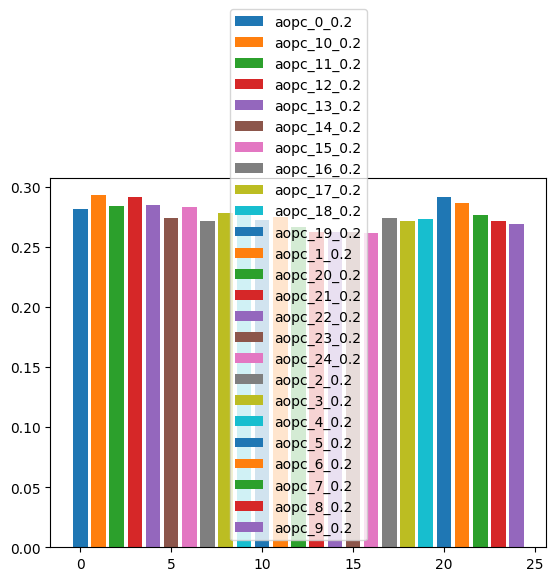

In [7]:
# aopc = make_key(avg2.keys(), 'aopc', '0.2')

avg = avg2
method = "aopc"
ratio = "0.2"

check_key = []
for i in list(avg.keys()):
    if ratio in i:
        if method in i:
            # print(i)
            check_key.append(i)

print(check_key)

result = []
for i in check_key:
    result.append(avg[f'{i}'])

print(result)
                
for i in range(len(check_key)):
    plt.bar(i, result[i], label = f'{check_key[i]}')
    plt.legend(loc = 8)
    # plt.bar(check_key, result)




In [10]:
sort_aopc = [
 'aopc_0_0.2',
 'aopc_1_0.2',
 'aopc_2_0.2',
 'aopc_3_0.2',
 'aopc_4_0.2',
 'aopc_5_0.2',
 'aopc_6_0.2',
 'aopc_7_0.2',
 'aopc_8_0.2',
 'aopc_9_0.2', 
 'aopc_10_0.2',
 'aopc_11_0.2',
 'aopc_12_0.2',
 'aopc_13_0.2',
 'aopc_14_0.2',
 'aopc_15_0.2',
 'aopc_16_0.2',
 'aopc_17_0.2',
 'aopc_18_0.2',
 'aopc_19_0.2',
 'aopc_20_0.2',
 'aopc_21_0.2',
 'aopc_22_0.2',
 'aopc_23_0.2',
 'aopc_24_0.2',
]
# sort_key
sort_morf = [
 'morf_0_0.2',
 'morf_1_0.2',
 'morf_2_0.2',
 'morf_3_0.2',
 'morf_4_0.2',
 'morf_5_0.2',
 'morf_6_0.2',
 'morf_7_0.2',
 'morf_8_0.2',
 'morf_9_0.2', 
 'morf_10_0.2',
 'morf_11_0.2',
 'morf_12_0.2',
 'morf_13_0.2',
 'morf_14_0.2',
 'morf_15_0.2',
 'morf_16_0.2',
 'morf_17_0.2',
 'morf_18_0.2',
 'morf_19_0.2',
 'morf_20_0.2',
 'morf_21_0.2',
 'morf_22_0.2',
 'morf_23_0.2',
 'morf_24_0.2',
]

sort_pred = [
 'pred_0_0.2',
 'pred_1_0.2',
 'pred_2_0.2',
 'pred_3_0.2',
 'pred_4_0.2',
 'pred_5_0.2',
 'pred_6_0.2',
 'pred_7_0.2',
 'pred_8_0.2',
 'pred_9_0.2', 
 'pred_10_0.2',
 'pred_11_0.2',
 'pred_12_0.2',
 'pred_13_0.2',
 'pred_14_0.2',
 'pred_15_0.2',
 'pred_16_0.2',
 'pred_17_0.2',
 'pred_18_0.2',
 'pred_19_0.2',
 'pred_20_0.2',
 'pred_21_0.2',
 'pred_22_0.2',
 'pred_23_0.2',
 'pred_24_0.2',
]

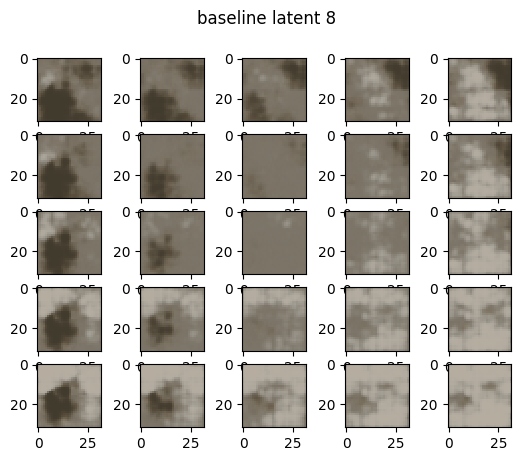

In [107]:
baseline = torch.load('/home/dhlee/code/ig_inversion/results/baseline/cifar10_baseline_8.pt', map_location='cpu')

fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat

for i in range(25):
    ax = next(axes_flat)
    ax.imshow(convert_to_img(baseline[i]))
    plt.suptitle('baseline latent 8')

In [ ]:
a = [avg2, avg8]
b = [sort_aopc, sort_aopc1]
c = [sort_morf, sort_morf1]

r = [0.1, 0.2]
l = [2, 8]

for i in range(len(l)):
    avg = a[i]
    
    for j in range(len(r)):
        ao = b[j]
        mo = c[j]

        res_aopc = []
        for k in ao:
            res_aopc.append(avg[f'{k}'])
            
        arr_aopc = np.array(res_aopc)
        arr_aopc = arr_aopc.reshape((5, 5))

        res_morf = []
        for k in mo:
            res_morf.append(avg[f'{k}'])
            
        arr_morf = np.array(res_morf)
        arr_morf = arr_morf.reshape((5, 5))

        fig, ax = plt.subplots(1,1)
        sns.heatmap(arr_aopc, cmap='bwr', annot=True, fmt='0.3f', xticklabels=axis, yticklabels=axis, )
        # cb = ax.collections[-1].colorbar
        # cb.ax.plot([-100, 100], [zero_score-(1e-7) , zero_score + (1e-7)], 'green', lw=3, ls='-')
        plt.title(f'aopc, latent_{l[i]}, ratio {r[j]}')
        plt.savefig(f'/home/dhlee/code/ig_inversion/figure/cifar/pdf/aopc_latent_{l[i]}_ratio_{r[j]}.pdf')
        
        fig, ax = plt.subplots(1,1)
        sns.heatmap(arr_morf, cmap='bwr', annot=True, fmt='0.3f', xticklabels=axis, yticklabels=axis, )
        # cb = ax.collections[-1].colorbar
        # cb.ax.plot([-100, 100], [zero_score-(1e-7) , zero_score + (1e-7)], 'green', lw=3, ls='-')
        plt.title(f'morf, latent_{l[i]}, ratio {r[j]}')
        plt.savefig(f'/home/dhlee/code/ig_inversion/figure/cifar/pdf/morf_latent_{l[i]}_ratio_{r[j]}.pdf')
    
# avg = avg2
# res_aopc = []
# for i in sort_aopc1:
#     res_aopc.append(avg[f'{i}'])
    
# arr_aopc = np.array(res_aopc)
# arr_aopc = arr_aopc.reshape((5, 5))
# arr_aopc


# res_morf = []
# for i in sort_morf1:
#     res_morf.append(avg[f'{i}'])
    
# arr_morf = np.array(res_morf)
# arr_morf = arr_morf.reshape((5, 5))
# # arr_aopc



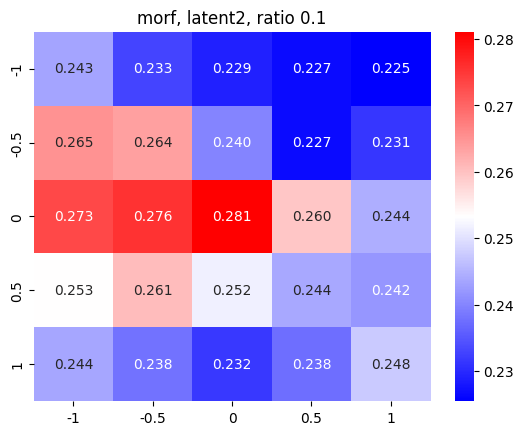

In [163]:
import seaborn as sns
axis = [-1, -0.5, 0, 0.5, 1]
zero_score = 0.366

fig, ax = plt.subplots(1,1)
sns.heatmap(arr_aopc, cmap='bwr', annot=True, fmt='0.3f', xticklabels=axis, yticklabels=axis, )
cb = ax.collections[-1].colorbar
cb.ax.plot([-100, 100], [zero_score-(1e-7) , zero_score + (1e-7)], 'green', lw=3, ls='-')
plt.title('morf, latent2, ratio 0.1')
plt.savefig('/home/dhlee/code/ig_inversion/figure/cifar/pdf/aopc_latent_2_ratio_0_1.pdf')

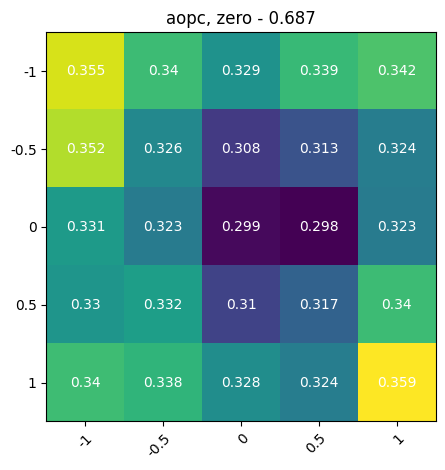

In [62]:
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

fig, ax = plt.subplots()
im = ax.imshow(arr_morf)

axis = [-1, -0.5, 0, 0.5, 1]

# We want to show all ticks...
ax.set_xticks(np.arange(len(axis)))
ax.set_yticks(np.arange(len(axis)))
# ... and label them with the respective list entries
ax.set_xticklabels(axis)
ax.set_yticklabels(axis)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(axis)):
    for j in range(len(axis)):
        text = ax.text(j, i, round(arr_morf[i, j], 3),
                       ha="center", va="center", color="w")

ax.set_title("aopc, zero - 0.687")
fig.tight_layout()
plt.show()

class specific score (aopc, morf)

In [99]:
with open("/home/dhlee/code/ig_inversion/results/json/class_index_cifar10.json", "r") as st_json:
    index = json.load(st_json)

In [79]:
def class_spec(index, all, label, sort_method):
    idx = index[f'{label}'] # list /  label - index
    
    result  = {}
    average ={}
    for i in sort_method:
        temp = np.array(all[i]) # method 
        out = temp[idx]
        result[i] = out
        average[i] = np.mean(out)
    return result, average

def convert_dict_array(dic, sort_key):
    result = []
    for i in sort_key:
        result.append(dic[i])
    result = np.array(result).reshape((5, 5))
    return result

def convert_dict_list(dic, sort_key):
    result = []
    for i in sort_key:
        result.append(dic[i])
    return result

def morf_baseline_class(index, dic, sort_morf):    
    score = {}
    for i in sort_morf:
        temp = np.array(dic[i])
        sc = {}
        for j in range(10):
            idx = np.array(index[f'{j}'])
            sc[f'{j}'] = sum(temp[idx])
        score[i] = sc
    return score 

num_str = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [37]:
# aopc, morf
def class_spec(index, all, label, sort_method):
    idx = index[f'{label}'] # list /  label - index
    
    result  = {}
    average ={}
    for i in sort_method:
        temp = np.array(all[i]) # method 
        out = temp[idx]
        result[i] = out
        average[i] = np.mean(out)
    return result, average


class_aopc_2 = {}
class_avg_aopc_2 = {}
for i in range(10):            
    al, av = class_spec(index, all2, i, sort_aopc)
    class_aopc_2[f'{i}'] = al
    class_avg_aopc_2[f'{i}'] = av

class_aopc_8 = {}
class_avg_aopc_8 = {}
for i in range(10):            
    al, av = class_spec(index, all8, i, sort_aopc)
    class_aopc_8[f'{i}'] = al
    class_avg_aopc_8[f'{i}'] = av


In [ ]:
for i in range(10):
    plt.figure()
    temp = convert_dict_array(class_avg_aopc_8[f'{i}'], sort_aopc)
    sns.heatmap(temp, cmap='bwr', annot=True, fmt='0.3f', cbar=True,  xticklabels=axis, yticklabels=axis, )
    plt.title(f'aopc, latent 8, label {i}')
    plt.savefig(f'/home/dhlee/code/ig_inversion/figure/cifar/latent8/aopc_latent_8_class_{i}')

In [78]:
# init
# score_aopc = {}
# for i in range(10):
#     j = str(i)
#     score_aopc[j] = 0
# score_aopc

# 
# for i in range(10):
#     temp = index[f'{i}']
#     temp_aopc  = []
#     for j in sort_key:
#         temp_method = all[j]
#         temp_aopc.append(temp_method[temp])
#         break
#     # score_aopc['']
#     break
# temp_aopc

class_aopc = {}
class_mean_aopc = {}
for i in sort_key:
    temp_method = np.array(all[i])
    temp_dict = {}
    mean_dict = {}
    for j in range(10):
        temp_idx = index[f'{j}']
        temp = temp_method[temp_idx]
        
        
        mean_dict[f'{j}']=np.mean(temp)
        temp_dict[f'{j}']=temp
        
    class_mean_aopc[i] = mean_dict
    class_aopc[i] = temp_dict


class_morf = {}
class_mean_morf = {}
for i in sort_morf:
    temp_method = np.array(all[i])
    temp_dict = {}
    mean_dict = {}
    for j in range(10):
        temp_idx = index[f'{j}']
        temp = temp_method[temp_idx]
        
        
        mean_dict[f'{j}']=np.mean(temp)
        temp_dict[f'{j}']=temp
        
    class_mean_morf[i] = mean_dict
    class_morf[i] = temp_dict
    
    #     # print(len(temp_idx))
    #     # print(len(temp))
    #     break
    # # print(temp_method)
    # break

In [96]:
class_aopc_inv = {}
class_mean_aopc_inv = {}
for i in range(10):
    temp_idx = index[f'{i}']
    
    temp_dict = {}
    mean_dict = {}
    for j in sort_key:
        temp_method = np.array(all[j])
        temp = temp_method[temp_idx]        
        
        mean_dict[f'{j}']=np.mean(temp)
        temp_dict[f'{j}']=temp
        
    class_mean_aopc_inv[i] = mean_dict
    class_aopc_inv[i] = temp_dict

class_morf_inv = {}
class_mean_morf_inv = {}
for i in range(10):
    temp_idx = index[f'{i}']
    
    temp_dict = {}
    mean_dict = {}
    for j in sort_morf:
        temp_method = np.array(all[j])
        temp = temp_method[temp_idx]        
        
        mean_dict[f'{j}']=np.mean(temp)
        temp_dict[f'{j}']=temp
        
    class_mean_morf_inv[i] = mean_dict
    class_morf_inv[i] = temp_dict

In [105]:

# class_mean_aopc_inv
for i in range(10):
    plt.figure()
    res_morf = []
    # temp = class_aopc_inv[f'{i}']
    temp = class_mean_morf_inv[i]
    for j in sort_morf:
        res_morf.append(temp[f'{j}'])
        
    arr_morf = np.array(res_morf)
    arr_morf = arr_morf.reshape((5, 5))
    
    # ax = next(axes_flat)
    # axes_flat[i] = sns.heatmap(arr_morf, cmap='bwr', annot=True, fmt='0.3f', cbar=True,  xticklabels=axis, yticklabels=axis, )
    sns.heatmap(arr_morf, cmap='bwr', annot=True, fmt='0.3f', cbar=True,  xticklabels=axis, yticklabels=axis, )
    plt.title(f'morf - {i}')
    # ax.show()
# plt.show()


In [ ]:
axis_num = np.arange(10)
m = 0
for i in sort_pred:
    plt.figure(figsize=(15,15))
    ans = np.zeros((10, 10))
    pr = all8[i]
    for j in range(10):
        idx = index[f'{j}']
        for k in idx:
            col = pr[k]
            ans[j][col] += 1
    # print(pr)
    sns.heatmap(ans, cmap='plasma', annot=True, cbar=True, xticklabels=axis_num, yticklabels=axis_num,)
    plt.ylabel('True')
    plt.xlabel('predicted')
    plt.title(f'latent 8 baseline {m} - remove 20%')
    # plt.savefig(f'/home/dhlee/code/ig_inversion/figure/cifar/latent2/prediction_latent_8_baseline_{m}.png')
    m += 1
    # break
        

In [126]:
# right2 = []
# for i in sort_morf:
#     temp = all2[i]
    
#     idx = []
#     for j in range(len(temp)):
#         if temp[j]: idx.append(j)
#     right2.append(idx)
    
def morf_baseline_class(index, dic, sort_morf):    
    score = {}
    for i in sort_morf:
        temp = np.array(dic[i])
        sc = {}
        for j in range(10):
            idx = np.array(index[f'{j}'])
            sc[f'{j}'] = sum(temp[idx])
        score[i] = sc
    return score   

def morf_baseline_class_inv(index, dic, sort_morf):    
    score = {}
    
    for i in range(10):
        idx = np.array(index[f'{i}'])            
        sc = {}
        for j in sort_morf:
            temp = np.array(dic[j])
            sc[f'{j}'] = sum(temp[idx])
        score[f'{i}'] = sc
    return score            

class_score2 = morf_baseline_class(index, all2, sort_morf)
class_score8 = morf_baseline_class(index, all8, sort_morf)

class_score2_inv = morf_baseline_class_inv(index, all2, sort_morf)
class_score8_inv = morf_baseline_class_inv(index, all8, sort_morf)


In [123]:
class_score8_inv

{0: {'morf_0_0.2': 567,
  'morf_1_0.2': 566,
  'morf_2_0.2': 547,
  'morf_3_0.2': 563,
  'morf_4_0.2': 548,
  'morf_5_0.2': 571,
  'morf_6_0.2': 558,
  'morf_7_0.2': 548,
  'morf_8_0.2': 565,
  'morf_9_0.2': 592,
  'morf_10_0.2': 547,
  'morf_11_0.2': 574,
  'morf_12_0.2': 557,
  'morf_13_0.2': 572,
  'morf_14_0.2': 581,
  'morf_15_0.2': 559,
  'morf_16_0.2': 570,
  'morf_17_0.2': 600,
  'morf_18_0.2': 579,
  'morf_19_0.2': 571,
  'morf_20_0.2': 594,
  'morf_21_0.2': 621,
  'morf_22_0.2': 608,
  'morf_23_0.2': 600,
  'morf_24_0.2': 582},
 1: {'morf_0_0.2': 792,
  'morf_1_0.2': 810,
  'morf_2_0.2': 819,
  'morf_3_0.2': 821,
  'morf_4_0.2': 819,
  'morf_5_0.2': 785,
  'morf_6_0.2': 789,
  'morf_7_0.2': 822,
  'morf_8_0.2': 813,
  'morf_9_0.2': 812,
  'morf_10_0.2': 798,
  'morf_11_0.2': 808,
  'morf_12_0.2': 790,
  'morf_13_0.2': 825,
  'morf_14_0.2': 827,
  'morf_15_0.2': 823,
  'morf_16_0.2': 816,
  'morf_17_0.2': 801,
  'morf_18_0.2': 816,
  'morf_19_0.2': 819,
  'morf_20_0.2': 836,
 

In [ ]:
fig, axes = plt.subplots(5, 2, figsize = (15, 15))
axes_flat = axes.flat
for i in range(10):
    ax = next(axes_flat)
    ax.bar(np.arange(len(sort_morf)), convert_dict_list(class_score2_inv[f'{i}'], sort_morf))
    temp = convert_dict_list(class_score2_inv[f'{i}'], sort_morf)
    # ax.set_ylim([0, 1000])
    # ax.set_ylim([min(temp) - 50, max(temp) + 50])
    ax.set_title(i)

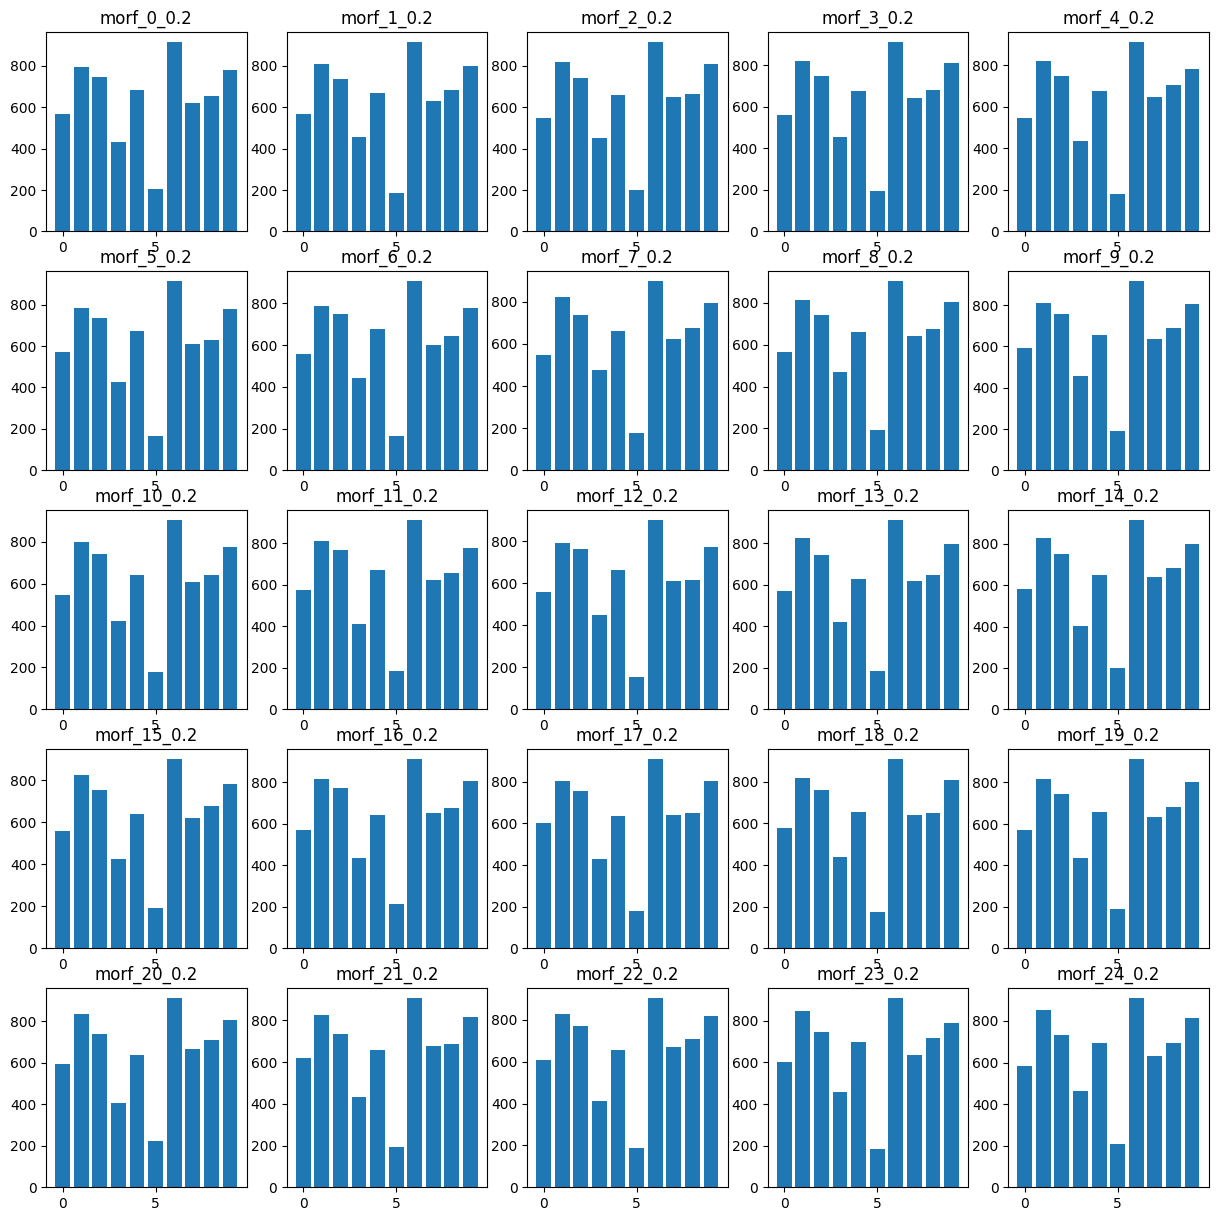

In [86]:
fig, axes = plt.subplots(5, 5, figsize = (15, 15))
axes_flat = axes.flat
for i in sort_morf:
    ax = next(axes_flat)
    ax.bar(np.arange(10), convert_dict_list(class_score2[i], num_str))
    ax.set_title(i)


class 5 analysis

In [ ]:
for i in range(10):
    idx_5 = index[f'{i}']

    fig, axes = plt.subplots(5, 5)
    axes_flat = axes.flat
    for i in range(25):
        ax = next(axes_flat)
        input = valid_dataset[idx_5[i]][0]
        # print(valid_dataset[idx_5[i]][1])
        ax.imshow(convert_to_img(input))
        

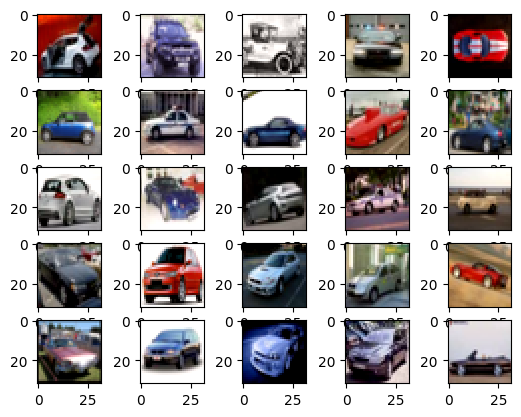

In [133]:

idx_5 = index[f'1']

fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat
for i in range(25):
    ax = next(axes_flat)
    input = valid_dataset[idx_5[i]][0]
    # print(valid_dataset[idx_5[i]][1])
    ax.imshow(convert_to_img(input))

In [ ]:
# check accuracy of model
from tqdm import tqdm
sc = {}
model = classifier.eval().to(device)
for i, j in enumerate(tqdm(valid_dataset)):
    input, label = j
    input = input.unsqueeze(0).to(device)
    
    output = model(input)
    pred = torch.argmax(output, dim=-1).item()

    if label == pred: pass
    else:
        if str(label) in sc.keys():
            sc[f'{label}'] += 1
        else:
            sc[f'{label}'] = 1
"""
{'0': 82,
 '1': 33,
 '4': 89,
 '3': 190,
 '5': 136,
 '9': 62,
 '2': 98,
 '6': 48,
 '7': 71,
 '8': 46}
 """

In [210]:
def image_heatmap(model, x, y, baseline, interpolation, device, **kwrags): 
#     x = x.to(device)
#     baseline = baseline.to(device)
#     interpolation = interpolation.to(device)
    model.zero_grad()
    x = x.to(device)
    baseline = baseline.to(device)
    
    X = Variable(interpolation, requires_grad=True).to(device)
    X.retain_grad()
    
    output = model(X,)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(X.size(0), output.size()[-1]).zero_().to(device).type(X.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)

    gradient = X.grad  #Approximate the integral using the trapezoidal rule
    # gradient = (gradient[:-1] + gradient[1:]) / 2.0
    # print(1, gradient.shape)
    output = (x - baseline).unsqueeze(0) * gradient
    # print(2, output.shape)
    output = output.mean(dim=1) # RGB mean
    # print(3, output.shape)
    output = output.abs()
    return output, gradient.mean(dim=1)

# out = image_heatmap(model, img, 5, baseline_temp, t, device)
# out.shape

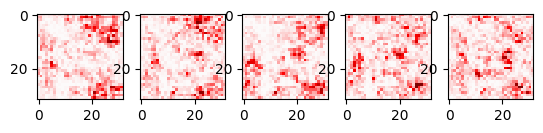

In [179]:
from ig_pkg.misc import process_heatmap
fig, axes = plt.subplots(1, 5)
axes_flat = axes.flat

for i in range(5):
    R = out[i]
    attr, kwargs = process_heatmap(R)
 
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)

In [220]:
grad.mean(dim=0)

tensor([[ 0.1007,  0.0993, -0.0027,  ...,  0.0040, -0.0419, -0.0484],
        [ 0.0340, -0.1985,  0.0250,  ...,  0.0085, -0.0462,  0.0435],
        [-0.4573,  0.3731, -0.2121,  ...,  0.1516,  0.0661,  0.0382],
        ...,
        [-0.0591,  0.1520, -0.0988,  ..., -0.1248, -0.2297,  0.1173],
        [ 0.0276, -0.0034,  0.0327,  ...,  0.0575,  0.0664,  0.0185],
        [-0.0594,  0.0417, -0.0058,  ..., -0.0485,  0.0957, -0.0439]],
       device='cuda:7')

tensor([4, 3, 3, 3, 5, 5, 5, 5, 5, 5], device='cuda:7')


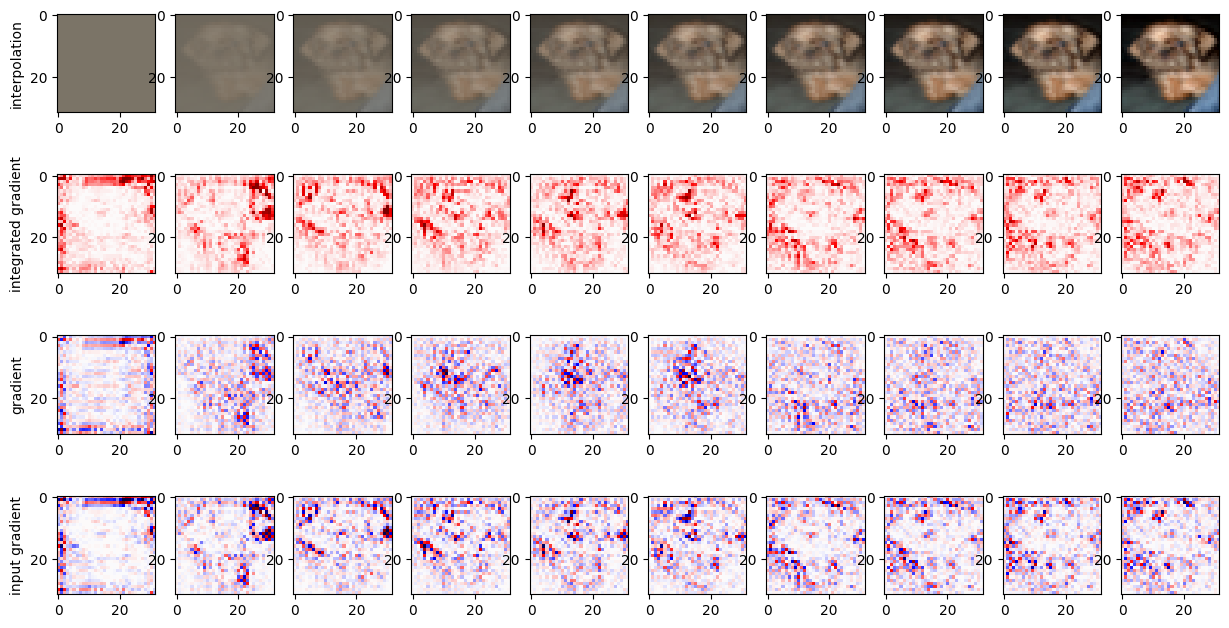

In [221]:
lab = []
idx_5 = index[f'5']
img = valid_dataset[idx_5[12]][0]
# baseline = torch.load('/home/dhlee/code/ig_inversion/results/baseline/cifar10_baseline_2.pt', map_location='cpu')
baseline_temp = torch.zeros_like(img)

# linear interpolation 
# fig, axes = plt.subplots(50, 10, figsize=(15, 60))
fig, axes = plt.subplots(4, 10, figsize=(15, 8))
axes_flat = axes.flat

t = linear_interpolation(img, 9, baseline_temp)

lab.append(torch.argmax(model(t.to(device)), dim=-1).tolist())
print(torch.argmax(model(t.to(device)), dim=-1))
out, grad = image_heatmap(model, img, 5, baseline_temp, t, device)

for j in range(10):
    ax = next(axes_flat)
    if j == 0: ax.set_ylabel('interpolation')
    ax.imshow(convert_to_img(t[j]))

for j in range(10):
    R = out[j]
    attr, kwargs = process_heatmap(R)

    ax = next(axes_flat)
    if j == 0: ax.set_ylabel('integrated gradient')
    ax.imshow(attr, **kwargs)

for j in range(10):
    R = grad[j]
    attr, kwargs = process_heatmap(R)

    ax = next(axes_flat)
    if j == 0: ax.set_ylabel('gradient')
    ax.imshow(attr, **kwargs)

for j in range(10):
    R = img.mean(dim=0) * grad[j].detach().cpu()
    attr, kwargs = process_heatmap(R)

    ax = next(axes_flat)
    if j == 0: ax.set_ylabel('input gradient')
    ax.imshow(attr, **kwargs)


tensor([5, 5, 3, 3, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([5, 5, 3, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([0, 3, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 3, 3, 3, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([5, 3, 3, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([4, 3, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 3, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 3, 3, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 3, 3, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 3, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 3, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([3, 3, 3, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([8, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:7')
tensor([8, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='c

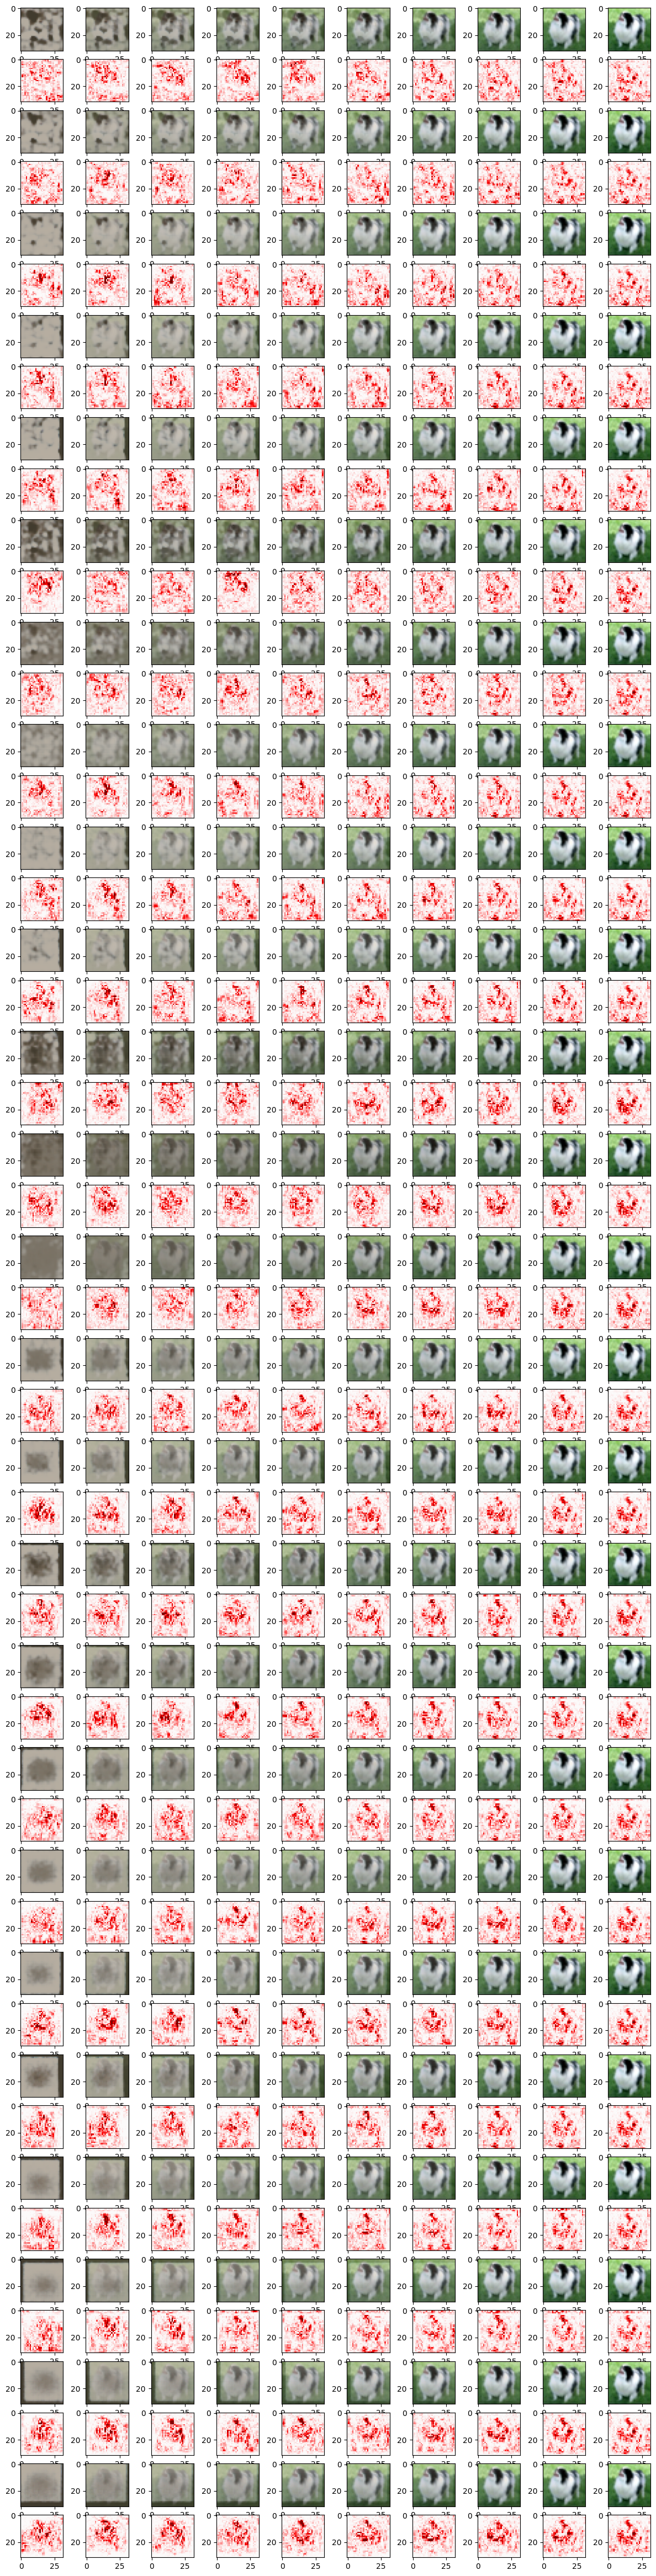

In [205]:
lab = []
for ix in range(10):
    idx_5 = index[f'5']
    img = valid_dataset[idx_5[10]][0]
    baseline = torch.load('/home/dhlee/code/ig_inversion/results/baseline/cifar10_baseline_2.pt', map_location='cpu')

    # linear interpolation 
    fig, axes = plt.subplots(50, 10, figsize=(15, 60))
    # fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    axes_flat = axes.flat
    
    for i in range(25):
        baseline_temp = baseline[i]
        # print(baseline_temp.shape)
        
        t = linear_interpolation(img, 9, baseline_temp)
        
        lab.append(torch.argmax(model(t.to(device)), dim=-1).tolist())
        print(torch.argmax(model(t.to(device)), dim=-1))
        out = image_heatmap(model, img, 5, baseline_temp, t, device)

        for j in range(10):
            ax = next(axes_flat)
            ax.imshow(convert_to_img(t[j]))
        
        for j in range(10):
            R = out[j]
            attr, kwargs = process_heatmap(R)
        
            ax = next(axes_flat)
            ax.imshow(attr, **kwargs)
            
    break
    
    
    

In [226]:
a = np.zeros((3, 3, 3))

np.save('/home/dhlee/code/ig_inversion/results/-1.npy', a)

In [138]:
from ig_pkg.utils.saliency import SaliencyGenerator
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

Gen = SaliencyGenerator()

ou = Gen.ig(img, 5, model, device, 24, 'max')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: type object 'SaliencyGenerator' has no attribute 'make_interpolation'

baseline analysis

In [199]:
logit = model(baseline.to(device))
torch.argmax(logit, dim=-1)

tensor([5, 5, 3, 3, 0, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 2, 2, 8, 3,
        8], device='cuda:7')

In [201]:
torch.argmax(model(t.to(device)), dim=-1)

tensor([8, 8, 8, 6, 6, 6, 6, 6, 6, 6], device='cuda:7')

etc

In [ ]:
pr = 'aopc_image_gradient_0.01'
re = "".join(reversed(pr))
print(pr.find('_'))
print(re.find('_'))
print(len(pr)- re.find('_'))
print(pr[4], pr[20 - 1])
print(pr[4+1:20-1])

In [49]:
from tqdm import tqdm
device='cuda:5'
# classifier = torch.load('/data8/donghun/cifar10/results/densenet/script_model.pt', map_location='cpu').eval().to(device)
# classifier = mo.eval().to(device)
classifier = model.eval().to(device)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=False, num_workers=2)

sc = 0
for i, j in enumerate(tqdm(valid_dataloader)):
    input, labe = j
    labe = labe.to(device)
    input = input.to(device)
    hat = torch.argmax(classifier(input), dim=-1)
    # print(hat)
    
    c = (hat==labe).sum().item()
    # print(c)
    sc += c
    # break
    

100%|██████████| 3750/3750 [00:10<00:00, 351.27it/s]
